<a href="https://colab.research.google.com/github/cahitcanuzman/Explainability-in-MMSD/blob/firstbranch/visualbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -q /content/gdrive/MyDrive/Data_Filming/data.zip
!cp /content/gdrive/MyDrive/Data_Filming/im_data.pickle /content/data
#!mkdir /content/models
#!cp /content/gdrive/MyDrive/visbert_models/first_model.pth /content/models

In [ ]:
import torch
import os
import pickle
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import cv2 #opencv_python
import re
import spacy

from tqdm import tqdm
from torch.utils.data import Dataset, Subset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.autograd import Variable
from torch.nn.utils.clip_grad import clip_grad_norm_
from PIL import Image

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# t = torch.cuda.get_device_properties(0).total_memory
# print(t/(1024*1024*1024))

# Load Data

In [ ]:
def load_file(file):
    """A helper function to load a pickle dump of a given file."""
    with open(file, 'rb') as f:
       return pickle.load(f)

In [ ]:
train_data = load_file('data/train_data')
valid_data = load_file('data/valid_data')
test_data = load_file('data/test_data')
image_top = load_file('data/image_top')
im_data = load_file('data/im_data.pickle')

train_text = [str(item['text']) for item in train_data.values()]
valid_text = [str(item['text']) for item in valid_data.values()]
test_text = [str(item['text']) for item in test_data.values()]
top_text = [ " ".join(item) for item in image_top.values()]

train_labels = [int(item['label']) for item in train_data.values()]
valid_labels = [int(item['label']) for item in valid_data.values()]
test_labels = [int(item['label']) for item in test_data.values()]

train_id = [str(item) for item in train_data.keys()]
valid_id = [str(item) for item in valid_data.keys()]
test_id = [str(item) for item in test_data.keys()]
top_id = [ str(item) for item in image_top.keys()]

texts = train_text + valid_text + test_text + top_text

In [ ]:
print(len(top_text))
print(len(train_data))
print(len(valid_data))
print(len(test_data))


36468
19816
2410
2409


In [ ]:
train_text = load_file("data/train_text")
train_labels = load_file("data/train_labels")
train_id = load_file("data/train_id")
image_top = load_file("data/image_top") #top 5 attributes
valid_text = load_file("data/valid_text")
valid_labels = load_file("data/valid_labels")
valid_id = load_file("data/valid_id")
test_text = load_file("data/test_text")
test_labels = load_file("data/test_labels")
test_id = load_file("data/test_id")

In [ ]:
print(len(train_text), len(valid_text), len(test_text))
print(len(train_labels), len(valid_labels), len(test_labels))
print(len(train_id), len(valid_id), len(test_id))
print(len(top_text),len(top_id))

print((len(train_id) + len(valid_id) + len(test_id)))



19816 2410 2409
19816 2410 2409
19816 2410 2409
36468 36468
24635


# Prepare & Process Data

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install transformers
from transformers import DistilBertTokenizer, BertTokenizer, RobertaTokenizer
visualbert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # BERT tokenizer is compatible with VisualBERT
#distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.9 MB/s eta 0:00:00


## Custom Dataset and Data Loaders


In [ ]:
# TODO: functionize the dataset
class CustomDataset(Dataset):
    """
    This is our custom dataset class which will load the images, perform transforms on them,
    and load their corresponding labels.
    """
    def __init__(self, img_dir, labels, image_ids, texts, roberta_tokenizer, visualbert_tokenizer, im_data, attrs) -> None:
        """
        img_dir = dir in which images are located
        labels = list containing true (0/1) values
        text = list containing all the texts
        filenames = list containing the names of images
        transform = transformer to preprocess images
        """
        self.img_dir = img_dir
        self.labels = labels
        self.texts = texts
        self.roberta_tokenizer = roberta_tokenizer
        self.im_data = im_data
        self.attrs = attrs
        self.image_ids = image_ids
        self.visualbert_tokenizer = visualbert_tokenizer

    def __len__(self):
        return len(self.labels)

    def get_merged_attrs(self, attr_list):
      #create a list that stores merged versions of strings
        return str(' '.join(attr_list))

    def __getitem__(self, idx):
        # retrieve image
        im_idx = self.image_ids[idx]
        try:
            img_path = os.path.join(
                self.img_dir, "{}.jpg".format(str(im_idx))
            )
            img = Image.open(img_path)

        except Exception as e:
            print(e)

        # apply text processing
        text = re.sub(r'(\s)emoji\w+', '', self.texts[idx]) # filter emojis from text

        ##### VISUALBERT PROCESSING #####

        # apply image processing
        im_dict = self.im_data[str(im_idx)] # apply transformation pipeline to image
        visual_embeds = im_dict['pooled_feat'][:10]
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

        # for visualbert
        visbert_text = self.visualbert_tokenizer.encode_plus(
            text=text,  # the text to be encoded
            add_special_tokens=True,  # add [CLS] and [SEP]
            max_length = 180,
            padding='max_length',
            return_attention_mask = True,  # return the attention mask
            return_tensors = 'pt',  # return tensor
        )

        ##### CO-ATTENTION PROCESSING #####

        # #for co-attention module
        # coatt_text = self.roberta_tokenizer.encode_plus(
        #     text=text,  # the text to be encoded
        #     add_special_tokens=True,  # add [CLS] and [SEP]
        #     max_length = 180,
        #     padding='max_length',
        #     return_attention_mask = True,  # return the attention mask
        #     return_tensors = 'pt',  # return tensor
        # )

        # #apply attribute processing for co-attention module
        # attr = self.get_merged_attrs(self.attrs[int(im_idx)]) # prevent tokenizer to recognize five attrs as a whole
        # tokenized_attr = self.roberta_tokenizer.encode_plus(
        #     text=attr,  # the attribute list to be encoded
        #     add_special_tokens=True,  # add [CLS] and [SEP]
        #     max_length = 15,
        #     padding='max_length',
        #     return_attention_mask = True,  # return the attention mask
        #     return_tensors = 'pt',  # return tensor
        # )

        indexed_tokens_for_text = self.roberta_tokenizer(text)['input_ids']
        while len(indexed_tokens_for_text) < 180:
            indexed_tokens_for_text.append(1)
        tokens_tensor_text = torch.tensor(indexed_tokens_for_text)

        # attribute tokens for transformer pipeline
        attribute =  self.get_merged_attrs(self.attrs[int(im_idx)])
        #attribute = ' '.join(attribute)
        indexed_tokens_for_attribute = self.roberta_tokenizer(attribute)['input_ids']
        while len(indexed_tokens_for_attribute) < 15:
            indexed_tokens_for_attribute.append(1)
        tokens_tensor_attribute = torch.tensor(indexed_tokens_for_attribute)


        # construct data dict
        data_dict = {}

        visbert_text["input_ids"] = torch.squeeze(visbert_text["input_ids"], 0)
        visbert_text["token_type_ids"] = torch.squeeze(visbert_text["token_type_ids"], 0)
        visbert_text["attention_mask"] = torch.squeeze(visbert_text["attention_mask"], 0)
        visbert_inputs = visbert_text


        visbert_inputs["visual_embeds"] = visual_embeds.cpu()
        visbert_inputs["visual_token_type_ids"] = visual_token_type_ids
        visbert_inputs["visual_attention_mask"] = visual_attention_mask

        data_dict["label"] = self.labels[idx]
        # data_dict["texts"] = torch.squeeze(coatt_text["input_ids"], 0)
        # data_dict["attrs"] = torch.squeeze(tokenized_attr["input_ids"], 0)
        data_dict["texts"] = tokens_tensor_text
        data_dict["attrs"] = tokens_tensor_attribute
        data_dict["visualbert_inputs"] = visbert_inputs
        data_dict["idx"] = im_idx

        # # to be deleted
        # data_dict["texts_o"] = text
        # data_dict["attrs_o"] = attr


        #data_dict["bbox"] = im_dict['bbox']
        # data_dict["text_attention_mask"] = tokenized_text["attention_mask"]
        # data_dict["attr_attention_mask"] = tokenized_attr["attention_mask"]

        return data_dict

In [ ]:
# Data Loaders
BATCH_SIZE = 64

# img_dir, labels, image_ids, texts, roberta_tokenizer, visualbert_tokenizer, img_transformer, im_data, attrs
processed_train = CustomDataset(img_dir = 'data/dataset_image/',
                                labels = train_labels,
                                texts = train_text,
                                image_ids = train_id,
                                roberta_tokenizer = roberta_tokenizer,
                                visualbert_tokenizer = visualbert_tokenizer,
                                im_data = im_data,
                                attrs = image_top
                                )

processed_valid = CustomDataset(img_dir = 'data/dataset_image/',
                                labels = valid_labels,
                                texts = valid_text,
                                image_ids = valid_id,
                                roberta_tokenizer = roberta_tokenizer,
                                visualbert_tokenizer = visualbert_tokenizer,
                                im_data = im_data,
                                attrs = image_top
                                )

processed_test = CustomDataset(img_dir = 'data/dataset_image/',
                                labels = test_labels,
                                texts = test_text,
                                image_ids = test_id,
                                roberta_tokenizer = roberta_tokenizer,
                                visualbert_tokenizer = visualbert_tokenizer,
                                im_data = im_data,
                                attrs = image_top
                                )
# indices = np.arange(100, 9188)
# reduced_dataset = Subset(processed_train, indices)
# TODO: PLAY WITH THIS
dataloader_train = DataLoader(processed_train,
                              batch_size = BATCH_SIZE,
                              pin_memory=True,
                              shuffle = True,
                              num_workers=0,
                              drop_last = True)

dataloader_valid = DataLoader(processed_valid,
                              batch_size = BATCH_SIZE,
                              pin_memory=True,
                              shuffle = True,
                              num_workers=0,
                              drop_last = True)

dataloader_test  = DataLoader(processed_test,
                              batch_size = BATCH_SIZE,
                              pin_memory=True,
                              shuffle = True,
                              num_workers=0,
                              drop_last = True)


# Model Implementation

## Encoders


In [ ]:
## Text and Image Attribute Encoders
from transformers import DistilBertModel, VisualBertModel, VisualBertConfig, RobertaModel, XLNetModel

text_encoder = RobertaModel.from_pretrained('roberta-base')
attr_encoder = RobertaModel.from_pretrained('roberta-base')
# xlnet_encoder = XLNetModel.from_pretrained("xlnet-base-cased")

# roberta_encoder = RobertaModel.from_pretrained('roberta-base')
# attr_encoder = RobertaModel.from_pretrained('roberta-base')

config = VisualBertConfig()

# 10 - 8 % 78
# 6 - 12  %81
# 4 - 4  %80
# 4 - 12
# 8 - 16
#config.intermediate_size = 3072 * 2
#config.hidden_size = 1536
#config.hidden_act = "gelu_new"
#config.output_hidden_states= True
#config.output_attentions= True


config.num_hidden_layers = 6
config.num_attention_heads = 12
config.visual_embedding_dim = 2048


# Print the configuration
print(config)
visualbert = VisualBertModel(config)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisualBertConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "bypass_transformer": false,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "visual_bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "special_visual_initialize": true,
  "transformers_version": "4.33.1",
  "type_vocab_size": 2,
  "visual_embedding_dim": 2048,
  "vocab_size": 30522
}



## Co-Attention Module


In [ ]:
import math
class CoAttention(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = torch.nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.

        # initialize weights and biases
        torch.nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weights)

        self.tanh = torch.nn.Tanh()
        self.max_pool = torch.nn.MaxPool2d(kernel_size = (180,1))

    def forward(self, H, T, batch_size = BATCH_SIZE):
        # H.shape = batch_size, 360, 768
        # T.shape = batch_size, 13, 768
        T_tmp = T.clone()
        T = T.permute(0, 2, 1)
        z_1 = torch.matmul(H, self.weights)
        z_2 = torch.matmul(z_1, T)

        # print(self.weights.shape) # [768, 768]

        C = self.tanh(z_2)
        alpha = self.max_pool(C)

        # print(C.shape) batch_size, 360, 13
        # print(alpha.shape) batch_size, 1, 13
        HT = torch.matmul(alpha, T_tmp).resize(batch_size, self.size_in)

        return HT

    # def __init__(self, hidden_dim, k = 100):
    #     super().__init__()
    #     self.hidden_dim = hidden_dim

    #     self.tanh = nn.Tanh()

    #     self.W = nn.Parameter(torch.randn(self.hidden_dim, self.hidden_dim)) # parameterized (learnable) weight matrix
    #     self.W_v = nn.Parameter(torch.randn(k, self.hidden_dim)) # k x 768
    #     self.W_q = nn.Parameter(torch.randn(k, self.hidden_dim)) # k x 768

    #     self.w_hv = nn.Parameter(torch.randn(k, 1))
    #     self.w_hq = nn.Parameter(torch.randn(k, 1))

    # def forward(self, V, Q):
    #     #   Q: B x 15 x 768     V: B x 250 x 768
    #     Q_T = Q.permute(0, 2, 1)
    #     V_T = V.permute(0, 2, 1)

    #     C = self.tanh(torch.matmul(torch.matmul(V, self.W) , Q_T)) # B x 250 x 15
    #     #print(C.shape)

    #     H_v = self.tanh(torch.matmul(self.W_q, Q_T) + torch.matmul(torch.matmul(self.W_v, V_T), C)) # B x k x 15

    #     a_v = F.softmax(torch.matmul(torch.t(self.w_hv), H_v), dim=2) # B x 1 x 150

    #     v = torch.squeeze(torch.matmul(a_v, Q)) # B x 768

    #     return v

## Main Model


In [ ]:
class MainModel(nn.Module):
    """Main model architecture that consists of two main parts: VisualBERT and a Co-attention mechanism."""
    def __init__(self):
        super(MainModel, self).__init__()
        self.visualbert = visualbert.to(device)

        self.text_encoder = text_encoder.to(device)
        self.attr_encoder = attr_encoder.to(device)
        self.co_attention = CoAttention(768, 768).to(device)

        self.fc_end = nn.Linear(768+768+768, 2)
        self.sig = nn.Sigmoid()


    def forward(self, text, attr, visualbert_inputs, batch_size = BATCH_SIZE):
        #for visualbert
        out_visbert = self.visualbert(**visualbert_inputs)
        out1 = out_visbert.pooler_output

        #for co-attention
        text_embed = self.text_encoder.embeddings(input_ids=text)
        attr_embed = self.attr_encoder.embeddings(input_ids=attr)

        # output of co-attention module
        out3 = self.co_attention(text_embed, attr_embed, batch_size)

        # if len(out2.shape) == 1: # for running lime on single datapoint
        #   out2 = torch.unsqueeze(out2, 0)
        # [CLS] tokens to be used

        out2 = text_embed[:,0,:] # [B, 768]

        concat_out = torch.cat((out1, out2, out3), dim = 1)
        concat_out = self.fc_end(concat_out)
        final_out = self.sig(concat_out)

        return final_out

In [ ]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

def load_checkpoint(save_path, model, optimizer):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'], strict=False)
    optimizer.load_state_dict(state_dict['optimizer_state_dict'], strict=False)
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')

    return val_loss




## Model Instance, Loss Functions and Optimizer

In [ ]:
model = MainModel()
model = model.to(device)

optimizer = optim.Adam(
    [
        {'params': model.visualbert.parameters(), 'lr': 1e-5, 'weight_decay': 1e-3},
        {'params': model.text_encoder.parameters(), 'lr': 1e-3},
        {'params': model.attr_encoder.parameters(), 'lr': 1e-3},
        {'params': model.co_attention.parameters()},
        {'params': model.fc_end.parameters()},
    ], lr = 1e-4 , weight_decay = 1e-2
)

criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!mkdir '/content/models'
!cp '/content/gdrive/MyDrive/third_model.pth ' '/content/models/third_model.pth'

In [ ]:
save_path = '/content/models/third_model.pth'
loaded_model_loss =  load_checkpoint(save_path, model, criterion)

Model loaded from <== /content/models/third_model.pth


## Training Loop

In [ ]:
# training loop
num_epochs = 35
starttrain = time.time()
min_val_loss = 123123123
patience = 3
# set up the training loop
for epoch in range(num_epochs):

    print('-'*10)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    startepoch = time.time()
    epoch_loss = 0.0
    model.train()


    for i, data_dict in enumerate(tqdm(dataloader_train)):
        # retrieve data
        labels = data_dict["label"]
        texts = data_dict["texts"]
        attrs = data_dict["attrs"]
        visualbert_inputs = data_dict['visualbert_inputs'].to(device)

        labels = Variable(labels.to(device))
        texts = Variable(texts.to(device))
        attrs = Variable(attrs.to(device))

        y_pred = model(texts, attrs, visualbert_inputs)
        # print(y_pred)
        # print(y_pred.shape)
        # print(labels)
        # print(labels.shape)
        # compute the loss

        loss = criterion(y_pred, labels)


        # backpropagate the gradients
        model.zero_grad() # or model
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        epoch_loss += loss.item()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Batch Step [{}/{}]%'
                  .format(epoch+1, num_epochs, i+1, len(dataloader_train)))

        del loss, y_pred, labels, texts, attrs, visualbert_inputs

    epoch_loss /= len(dataloader_train)
    print('Epoch: {}, Training Loss: {:.3f}'.format(epoch+1, epoch_loss))

        ############## VALIDATION ##############
    model.eval()

    # Initialize variables for validation
    val_loss = 0.0
    correct = 0
    total = 0


    # Turn off gradient calculations
    with torch.no_grad():
        # Loop over validation data in batches
        for i, data_dict in enumerate(dataloader_valid):
            # retrieve data
            labels = data_dict["label"].to(device)
            texts = data_dict["texts"].to(device)
            attrs = data_dict["attrs"].to(device)
            visualbert_inputs = data_dict['visualbert_inputs'].to(device)

            y_pred = model(texts, attrs, visualbert_inputs)

            # compute the loss
            loss_model = criterion(y_pred, labels)
            val_loss += loss_model

            # Get predicted class
            _, predicted = torch.max(y_pred.data, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = 100. * correct / total
    val_loss /= len(dataloader_valid)

    print('Validation Loss: {:.3f}, Validation Accuracy: {:.2f}%'.format(val_loss, val_accuracy))
    endepoch = time.time()
    print("Epoch Time: " , endepoch - startepoch)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement_count = 0
        save_path = 'second_model.pth' #'first_model_epoch' + str(epoch) + '.pth'
        save_checkpoint(save_path, model, optimizer, val_loss)
        print("Model saved at epoch", epoch)
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping at epoch", epoch)
        break

#data augmentation
#metrics




endtrain = time.time()
print("Training: " , endtrain - starttrain)
print("TRAINING DONE")

----------
Epoch 1/35


  0%|          | 0/309 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 32%|███▏      | 100/309 [00:44<01:26,  2.41it/s]

Epoch [1/35], Batch Step [100/309]%


 65%|██████▍   | 200/309 [01:26<00:45,  2.39it/s]

Epoch [1/35], Batch Step [200/309]%


 97%|█████████▋| 300/309 [02:07<00:03,  2.43it/s]

Epoch [1/35], Batch Step [300/309]%


100%|██████████| 309/309 [02:11<00:00,  2.35it/s]


Epoch: 1, Training Loss: 0.676
Validation Loss: 0.591, Validation Accuracy: 70.35%
Epoch Time:  138.17325401306152
Model saved at epoch 0
----------
Epoch 2/35


 32%|███▏      | 100/309 [00:40<01:25,  2.46it/s]

Epoch [2/35], Batch Step [100/309]%


 65%|██████▍   | 200/309 [01:21<00:44,  2.45it/s]

Epoch [2/35], Batch Step [200/309]%


 97%|█████████▋| 300/309 [02:02<00:03,  2.44it/s]

Epoch [2/35], Batch Step [300/309]%


100%|██████████| 309/309 [02:05<00:00,  2.46it/s]


Epoch: 2, Training Loss: 0.376
Validation Loss: 0.363, Validation Accuracy: 95.10%
Epoch Time:  132.5730333328247
Model saved at epoch 1
----------
Epoch 3/35


 32%|███▏      | 100/309 [00:40<01:24,  2.47it/s]

Epoch [3/35], Batch Step [100/309]%


 65%|██████▍   | 200/309 [01:21<00:44,  2.47it/s]

Epoch [3/35], Batch Step [200/309]%


 97%|█████████▋| 300/309 [02:02<00:03,  2.47it/s]

Epoch [3/35], Batch Step [300/309]%


100%|██████████| 309/309 [02:05<00:00,  2.45it/s]


Epoch: 3, Training Loss: 0.333
Validation Loss: 0.361, Validation Accuracy: 95.23%
Epoch Time:  132.65478086471558
Model saved at epoch 2
----------
Epoch 4/35


 32%|███▏      | 100/309 [00:40<01:24,  2.46it/s]

Epoch [4/35], Batch Step [100/309]%


 65%|██████▍   | 200/309 [01:21<00:44,  2.45it/s]

Epoch [4/35], Batch Step [200/309]%


 97%|█████████▋| 300/309 [02:01<00:03,  2.49it/s]

Epoch [4/35], Batch Step [300/309]%


100%|██████████| 309/309 [02:05<00:00,  2.46it/s]


Epoch: 4, Training Loss: 0.332
Validation Loss: 0.362, Validation Accuracy: 95.14%
Epoch Time:  132.21710968017578
----------
Epoch 5/35


 32%|███▏      | 100/309 [00:40<01:24,  2.47it/s]

Epoch [5/35], Batch Step [100/309]%


 65%|██████▍   | 200/309 [01:21<00:44,  2.45it/s]

Epoch [5/35], Batch Step [200/309]%


 97%|█████████▋| 300/309 [02:01<00:03,  2.47it/s]

Epoch [5/35], Batch Step [300/309]%


100%|██████████| 309/309 [02:05<00:00,  2.46it/s]


Epoch: 5, Training Loss: 0.332
Validation Loss: 0.363, Validation Accuracy: 95.06%
Epoch Time:  132.17684674263
----------
Epoch 6/35


 32%|███▏      | 100/309 [00:40<01:24,  2.47it/s]

Epoch [6/35], Batch Step [100/309]%


 65%|██████▍   | 200/309 [01:21<00:44,  2.45it/s]

Epoch [6/35], Batch Step [200/309]%


 97%|█████████▋| 300/309 [02:01<00:03,  2.47it/s]

Epoch [6/35], Batch Step [300/309]%


100%|██████████| 309/309 [02:05<00:00,  2.46it/s]


Epoch: 6, Training Loss: 0.332
Validation Loss: 0.361, Validation Accuracy: 95.19%
Epoch Time:  132.49119997024536
Early stopping at epoch 5
Training:  821.7834651470184
TRAINING DONE


In [ ]:
model.eval()

# Initialize variables for validation
test_loss = 0.0
correct = 0
total = 0


with torch.no_grad():
    # Loop over validation data in batches
    for i, data_dict in enumerate(dataloader_test):
        # retrieve data
        labels = data_dict["label"].to(device)
        texts = data_dict["texts"].to(device)
        attrs = data_dict["attrs"].to(device)
        visualbert_inputs = data_dict['visualbert_inputs'].to(device)

        y_pred = model(texts, attrs, visualbert_inputs)
        # compute the loss
        # Get predicted class
        _, predicted = torch.max(y_pred.data, 1)
        loss_model = criterion(y_pred, labels)
        test_loss += loss_model



        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate validation accuracy and loss
test_accuracy = 100. * correct / total
test_loss /= len(dataloader_test)

In [ ]:
print(test_accuracy)
print(test_loss)

93.49662162162163
tensor(0.3783, device='cuda:0')


In [ ]:
if test_accuracy > 82:
    save_checkpoint(save_path, model, optimizer, min_val_loss)
else:
  print("didn't save it")

didn't save it


In [ ]:
!cp /content/best_model.pth /content/gdrive/MyDrive/visbert_models

# Explainability


In [ ]:
def unsqueezer(inputs) -> dict:
    """A helper function that takes a dict consisting of VisualBERT parameter
    inputs, unsqueezes and returns them back.
    (for single data points to give them batch size dimensionality)"""
    inputs_copy = inputs.copy()
    keys = list(inputs_copy.keys())
    for i in range(len(inputs_copy)):
      #if keys[i] != "visual_embed":
      inputs_copy[keys[i]] = torch.unsqueeze(inputs[keys[i]], 0)

    return inputs_copy

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=aeb33352f408df4b1d8651a1e6a59b1b6b2ec691334a3956de4559639ba10f5c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime.lime_image import LimeImageExplainer
from lime.lime_text import LimeTextExplainer

def explain_image_instance(
        predictor_fn,
        input_arr,
        init_params,
        explanation_params,
    ):
        """Explain image instance.

        Args:
            predictor_fn: Predictor function which takes in a batch of inputs (not single input).
            input_arr: Input image as an array without a batch dimension.
            init_params: Initialization parameters for LIME Explainer.
            explanation_params: Parameters for LIME Explainer.

        Returns:
            lime.lime_image.ImageExplanation:
                Explanation of the image with given arguments
        """

        # Create LIME explainer
        lime_explainer = LimeImageExplainer(**init_params)

        # Run LIME explainer
        exp = lime_explainer.explain_instance(
            input_arr, predictor_fn, **explanation_params
        )

        return exp

def explain_text_instance(
        predictor_fn,
        text,
        init_params,
        explanation_params,
    ):
        """Explain text instance.

        Args:
            predictor_fn: Predictor function which takes in a batch of inputs (not single input).
            text: Input text as a string.
            init_params: Initialization parameters for LIME Explainer.
            explanation_params: Parameters for LIME Explainer.

        Returns:
            lime.lime_text.TextExplanation:
                Explanation of the text with given arguments
        """

        # Create LIME explainer
        lime_explainer = LimeTextExplainer(**init_params)

        # Run LIME explainer
        exp = lime_explainer.explain_instance(text, predictor_fn, **explanation_params)

        return exp

In [ ]:
dic = next(iter(dataloader_train))

In [ ]:
for i in dic['visualbert_inputs'].values():
  #if len(i.shape) == 3 and i.shape[1] == 1:
    print(i.shape)


torch.Size([64, 180])
torch.Size([64, 180])
torch.Size([64, 180])
torch.Size([64, 10, 2048])
torch.Size([64, 10])
torch.Size([64, 10])


In [ ]:
idx = 125 #a random idx

# necessary info of the data point
ex_data = processed_valid[idx] # example data point dict
#print(ex_data)
im_idx = ex_data['idx'] # image index
cor_label = ex_data['label'] #correct label
texts = ex_data["texts"] # tokenized texts
attrs = ex_data["attrs"] # tokenized image attrs
visualbert_inputs = ex_data['visualbert_inputs'] # visualbert inputs



for i in unsqueezer(visualbert_inputs).values():
  #if len(i.shape) == 3 and i.shape[1] == 1:
    print(i.shape)

print("-" * 30)
print(texts.shape)
print(attrs.shape)
print(torch.unsqueeze(texts, 0).shape)
print(torch.unsqueeze(attrs, 0).shape)

torch.Size([1, 180])
torch.Size([1, 180])
torch.Size([1, 180])
torch.Size([1, 10, 2048])
torch.Size([1, 10])
torch.Size([1, 10])
------------------------------
torch.Size([180])
torch.Size([15])
torch.Size([1, 180])
torch.Size([1, 15])


In [ ]:
print(unsqueezer(visualbert_inputs)["input_ids"].shape)

torch.Size([1, 180])


In [ ]:
model = model.to('cpu')
with torch.no_grad():
  y_pred = model(torch.unsqueeze(texts, 0), torch.unsqueeze(attrs, 0), unsqueezer(visualbert_inputs), batch_size=1)
  _, predicted = torch.max(y_pred.data, 1)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
print(y_pred)
print(predicted)


tensor([[5.5511e-05, 9.9996e-01]])
tensor([1])


In [ ]:
img = retrieve_image(im_idx)
im2 = retrieve_image(im_idx, False)
im = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGRA2BGR)

print(type(im))
print(im.shape)
print(im)
#plt.imshow(im)
print(im_data[im_idx])
print(valid_text[0:10])
print(list(visualbert_inputs.keys()))

true label 1
predicted 1
shame my city is so ugly . # chicago  # lovethiscity


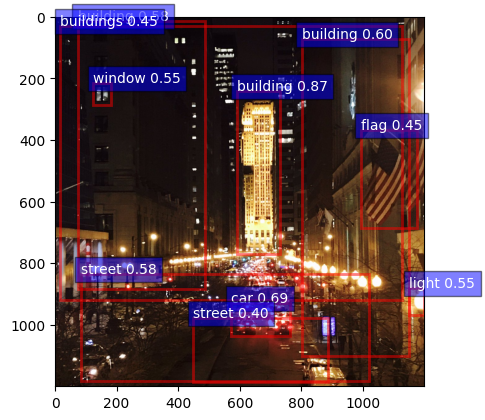

In [ ]:
plt.imshow(im)
bboxes = im_data[im_idx]['bbox']
for i in range(len(bboxes)):
  bbox = bboxes[i]
  cls = im_data[im_idx]['objs'][i]
  conf = im_data[im_idx]['confs'][i]

  plt.gca().add_patch(
      plt.Rectangle((bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1], fill=False,
                    edgecolor='red', linewidth=2, alpha=0.5)
          )
  plt.gca().text(bbox[0], bbox[1] - 2,
              '%s %.2f' % (cls, conf),
              bbox=dict(facecolor='blue', alpha=0.5),
              fontsize=10, color='white')

print("true label", cor_label)
print("predicted", predicted.item())
print(valid_text[idx])

## LIME Predictions


In [ ]:
import random
n_of_text_samples = 1000
idxx_list = []

while len(idxx_list) < n_of_text_samples:
  rand = random.randint(0, 2000)

  if rand not in idxx_list:
    idxx_list.append(rand)



In [ ]:
def retrieve_image(idx, pillow=True): # with long index
    img_dir = 'data/dataset_image/'
    try:
        img_path = os.path.join(
            img_dir,
            "{}.jpg".format(str(idx))
        )
    except Exception as e:
        print(e)

    if pillow:
        img = Image.open(img_path)
    else:
        img = cv2.imread(img_path)
    return img

In [ ]:
def get_merged_attrs(attr_list):
      #create a list that stores merged versions of strings
    return str(' '.join(attr_list))

def print_visbert(inp):
  for i in inp.values():
    print(i.shape)

In [ ]:
idxx_list = sorted(idxx_list)
print(idxx_list)
print(len(idxx_list))
ex_im_idxs = [valid_id[i] for i in idxx_list]
print(ex_im_idxs)
print(len(ex_im_idxs))

ex_texts = [re.sub(r'(\s)emoji\w+', '', valid_text[i]) for i in idxx_list]
print(ex_texts)
ex_attrs = [get_merged_attrs(image_top[int(i)]) for i in ex_im_idxs]
print(ex_attrs)

[39, 66, 81, 105, 108, 154, 161, 168, 246, 348, 360, 381, 387, 407, 487, 493, 495, 516, 537, 559, 573, 590, 595, 610, 629, 649, 654, 663, 701, 708, 709, 714, 715, 723, 728, 738, 744, 750, 795, 798, 814, 817, 821, 829, 834, 840, 857, 883, 913, 935, 949, 978, 996, 1019, 1053, 1064, 1104, 1123, 1146, 1150, 1192, 1205, 1211, 1229, 1275, 1287, 1308, 1356, 1409, 1441, 1447, 1460, 1479, 1484, 1517, 1579, 1620, 1629, 1640, 1649, 1655, 1699, 1703, 1727, 1732, 1737, 1753, 1786, 1794, 1801, 1805, 1832, 1833, 1853, 1870, 1893, 1945, 1948, 1981, 1989]
100
['733683602077048833', '712073195243737088', '719364179161980928', '709448351201230849', '907984892876742656', '687998090146496512', '933476808024043521', '852506690503274496', '712054527537455105', '883548554303754240', '822506680285921280', '823135852507308033', '923596397244448769', '913817050786566144', '907838901498335233', '923421319961513985', '731539431501500416', '894485890474663938', '903462968175689728', '830772099606208516', '895245047

### LIME text explanations

In [ ]:
coatt_attr = roberta_tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=ex_attrs,  # the text to be encoded
    add_special_tokens=True,  # add [CLS] and [SEP]
    max_length = 15,
    padding='max_length',
    return_attention_mask = True,  # return the attention mask
    return_tensors = 'pt',  # return tensor
  )

vis_embeds = [im_data[i]['pooled_feat'][:10].cpu() for i in ex_im_idxs]
ex_vis_embeds = torch.stack(vis_embeds)

visual_token_type_ids = torch.ones(ex_vis_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(ex_vis_embeds.shape[:-1], dtype=torch.float)

model = model.to('cpu')

In [ ]:
def text_predictor_fn(texts):

    visbert_text = visualbert_tokenizer.batch_encode_plus(
      batch_text_or_text_pairs=texts,  # the text to be encoded
      add_special_tokens=True,  # add [CLS] and [SEP]
      max_length = 180,
      padding='max_length',
      return_attention_mask = True,  # return the attention mask
      return_tensors = 'pt',  # return tensor
    )

    coatt_text = roberta_tokenizer.batch_encode_plus(
      batch_text_or_text_pairs=texts,  # the text to be encoded
      add_special_tokens=True,  # add [CLS] and [SEP]
      max_length = 180,
      padding='max_length',
      return_attention_mask = True,  # return the attention mask
      return_tensors = 'pt',  # return tensor
    )

    visbert_inputs = visbert_text.copy()
    visbert_inputs["visual_embeds"] = ex_vis_embeds
    visbert_inputs["visual_token_type_ids"] = visual_token_type_ids
    visbert_inputs["visual_attention_mask"] = visual_attention_mask

    # print(visbert_text)
    # print(visbert_text['input_ids'].shape)
    # print(coatt_text)
    # print(coatt_text['input_ids'].shape)

    # print(print_visbert(visbert_inputs))
    with torch.no_grad():

        y_pred = model(coatt_text["input_ids"], coatt_attr['input_ids'],
                       visbert_inputs, n_of_text_samples)
    return y_pred

#text_predictor_fn(ex_texts)

In [ ]:
rand_idx = 512
text_to_explain = re.sub(r'(\s)emoji\w+', '', valid_text[rand_idx])
corr_label = valid_labels[rand_idx]
init_params = {}

explanation_params = {
    "labels": (corr_label,),
    "num_samples": n_of_text_samples,
}



text_exp = explain_text_instance(text_predictor_fn, text_to_explain, init_params, explanation_params)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
text_exp.local_exp

{1: [(0, 3.4680693007304748e-06),
  (6, -2.716251902578984e-06),
  (5, -1.7453844386763523e-06),
  (9, -1.7396866606422896e-06),
  (7, -1.7196134735218213e-06),
  (3, 1.692725950407321e-06),
  (1, -1.4735707608913103e-06),
  (4, -1.1404245937827727e-06),
  (8, 2.702272695272813e-07),
  (2, 1.2737757633766658e-07)]}

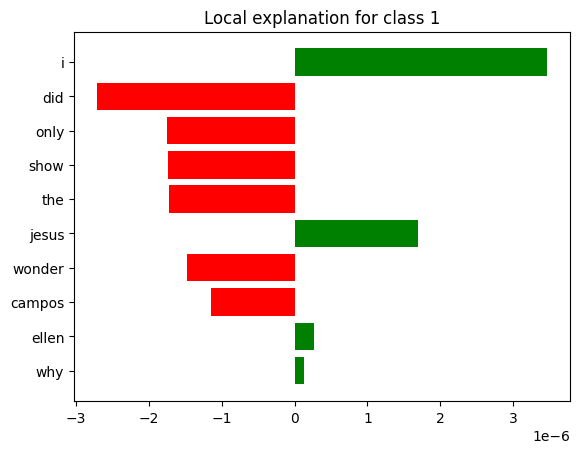

In [ ]:
text_bar = text_exp.as_pyplot_figure(label=corr_label)

### LIME image explanations

In [ ]:
!mkdir data/tmp_img

In [ ]:
n_of_im_samples = 5

In [ ]:
text_for_im = valid_text[rand_idx]
visbert_text_im = visualbert_tokenizer.batch_encode_plus(
    batch_text_or_text_pairs= text_for_im,  # the text to be encoded
    add_special_tokens=True,  # add [CLS] and [SEP]
    max_length = 180,
    padding='max_length',
    return_attention_mask = True,  # return the attention mask
    return_tensors = 'pt',  # return tensor
  )

coatt_text_im = roberta_tokenizer.batch_encode_plus(
    batch_text_or_text_pairs= text_for_im,  # the text to be encoded
    add_special_tokens=True,  # add [CLS] and [SEP]
    max_length = 180,
    padding='max_length',
    return_attention_mask = True,  # return the attention mask
    return_tensors = 'pt',  # return tensor
  )

coatt_attr_im = roberta_tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=ex_attrs,  # the text to be encoded
    add_special_tokens=True,  # add [CLS] and [SEP]
    max_length = 15,
    padding='max_length',
    return_attention_mask = True,  # return the attention mask
    return_tensors = 'pt',  # return tensor
  )


In [ ]:
def image_predictor_fn(images):
    im_dirs = []
    im_idxs = []
    print(images)
    print(len(images))
    for i in range(len(images)):
        plt.imsave(f"data/tmp_img/{i}.jpg", images[i])
        im_dirs.append(f"data/tmp_img/{i}.jpg")

    # vis_embeds = [im_data[i]['pooled_feat'][:10].cpu() for i in ex_im_idxs]
    # ex_vis_embeds = torch.stack(vis_embeds)

    # visual_token_type_ids = torch.ones(ex_vis_embeds.shape[:-1], dtype=torch.long)
    # visual_attention_mask = torch.ones(ex_vis_embeds.shape[:-1], dtype=torch.float)

    # visbert_inputs_im = visbert_text_im.copy()
    # visbert_inputs_im["visual_embeds"] = ex_vis_embeds
    # visbert_inputs_im["visual_token_type_ids"] = visual_token_type_ids
    # visbert_inputs_im["visual_attention_mask"] = visual_attention_mask


    # with torch.no_grad():
    #     y_pred = model(coatt_text_im["input_ids"], coatt_attr_im['input_ids'],
    #                    visbert_inputs_im, n_of_im_samples)

    # return y_pred



In [ ]:
init_params = {}
ex_im_idx = ex_im_idxs[11]
img = retrieve_image(ex_im_idx)
im = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGRA2BGR)
explanation_params = {
    "labels": (cor_label,),
    "hide_color": 0,
    "num_samples": n_of_im_samples,
    "batch_size": 5
}
image_exp = explain_image_instance(image_predictor_fn, im, init_params, explanation_params)

  0%|          | 0/5 [00:00<?, ?it/s]

[[[[123 123 131]
   [123 123 131]
   [123 123 131]
   ...
   [123 124 129]
   [123 124 129]
   [123 124 129]]

  [[123 123 131]
   [123 123 131]
   [123 123 131]
   ...
   [123 124 129]
   [123 124 129]
   [123 124 129]]

  [[123 123 131]
   [123 123 131]
   [123 123 131]
   ...
   [123 124 129]
   [123 124 129]
   [123 124 129]]

  ...

  [[ 17   0  18]
   [ 17   0  18]
   [ 17   0  18]
   ...
   [ 17   0  18]
   [ 17   0  18]
   [ 17   0  18]]

  [[ 17   0  18]
   [ 17   0  18]
   [ 17   0  18]
   ...
   [ 17   0  18]
   [ 17   0  18]
   [ 17   0  18]]

  [[ 17   0  18]
   [ 17   0  18]
   [ 17   0  18]
   ...
   [ 17   0  18]
   [ 17   0  18]
   [ 17   0  18]]]


 [[[123 123 131]
   [123 123 131]
   [123 123 131]
   ...
   [123 124 129]
   [123 124 129]
   [123 124 129]]

  [[123 123 131]
   [123 123 131]
   [123 123 131]
   ...
   [123 124 129]
   [123 124 129]
   [123 124 129]]

  [[123 123 131]
   [123 123 131]
   [123 123 131]
   ...
   [123 124 129]
   [123 124 129]
   [123 124

TypeError: ignored

# Google OCR and Unused

In [ ]:
import pytesseract
from pytesseract import Output


# for i in range(14): # page segmentation mode
#     for j in range(4): # ocr engine mode
try:
    myconfig = "--psm 12 --oem 3"
    text = pytesseract.image_to_string(img,config=myconfig) # 11-0 , 12-1,
    print(text)

except:
    print("error")
    pass # doing nothing on exception

i += 1



In [ ]:
# # boxes for chars
# imgg = retrieve_image(im_idx, False)
# hei, wid, _ = img.shape
# boxes = pytesseract.image_to_boxes(img) # ,config=myconfig
# print(boxes)

# for box in boxes.splitlines():
#     box = box.split(" ")
#     img = cv2.rectangle(img, (int(box[1]), hei - int(box[2]), int(box[3]), hei - int(box[4])), (0, 255, 0), 1) #bgr

# cv2.imshow("img", img)
# cv2.waitKey(0)


# data = pytesseract.image_to_data(img, config = myconfig, output_type= Output.DICT)
# print(data.keys())

#  # confidence for words
# boxam = len(data['text'])

# for i in range(boxam):
#     if float(data['conf'][i]) > 80:
#         (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i],)
#         img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
#         img = cv2.putText(img, data['text'][i], (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)


# Playing data

In [ ]:
print(train_text[train_id.index(str(im_idx))])
print(train_labels[train_id.index(str(im_idx))])

indices = [i for i, x in enumerate(train_labels) if x == 0] #non sarcastic indices
print(indices[0:10])
print(len(indices))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im_idx = int(train_id[i + 1080])
    plt.imshow(retrieve_image(im_idx))
    plt.title(str(train_text[train_id.index(str(im_idx))]) + " -- " + str(train_labels[train_id.index(str(im_idx))]))
    plt.axis("off")